# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [12]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    
    # set the model to train mode
    model.train()
    
    # Enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    if device == torch.device("cpu") and torch.backends.mps.is_available():
        device = torch.device("mps")
    for batch_id, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        
        # Set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # Run the network
        output = model(data)
        
        # Compute negative log likelihood loss
        loss = F.nll_loss(output, label)
        
        # Do backpropagation
        loss.backward()
        
        # Optimize
        optimizer.step() 
        
        # Print current loss for every nth ("log_interval"th) iteration
        if batch_id % log_interval == 0:
             print(f'Train Epoch: {epoch} [{batch_id * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_id / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [13]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            
            device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
            if device == torch.device("cpu") and torch.backends.mps.is_available():
                device = torch.device("mps")
            # transfer to GPU
            data = data.to(device)
            target = target.to(device)
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [14]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # Initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # Run network layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x) # Last layer does not need an activation function
        
        # Compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [15]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

In [16]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
        self.fc1 = nn.Linear(784, 200)
        self.bn1 = nn.BatchNorm1d(200) 
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.bn3 = nn.BatchNorm1d(60) # Batch Normalization layers
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [17]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # initialize network layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # run fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        
        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [18]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # initialize network layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # run convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        # reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # run fully connected layers
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.fc2(x) 
        
        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [19]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # initialize network layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # run convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        x = self.pool(x)
        
        # reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # run fully connected layers
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.fc2(x) 
        
        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Using device: mps
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311748
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.496410
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.266225
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.234749
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.208844
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.186921
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.122275
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.235470
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164461
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.025037

Test set: Average loss: 0.3116, Accuracy: 9192/10000 (91.92%)



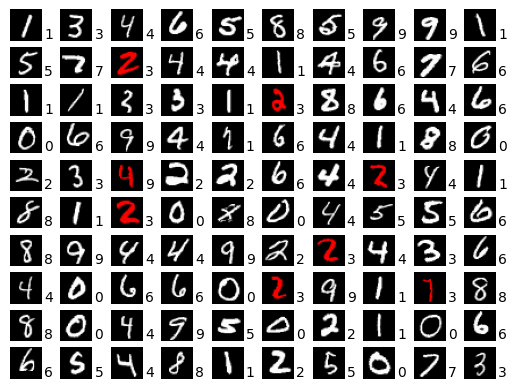

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.187822
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.026939
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.019654
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.070783
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.072161
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.114716
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.084083
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.101378
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.100871
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.083883

Test set: Average loss: 0.0839, Accuracy: 9747/10000 (97.47%)



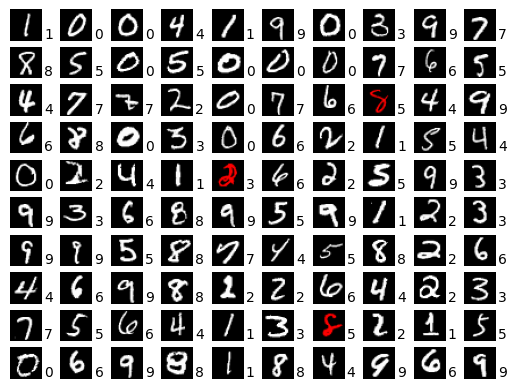

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.064781
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.040067
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.131086
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.007471
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.104209
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.015826
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.103077
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.123746
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.007400
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.093865

Test set: Average loss: 0.0781, Accuracy: 9786/10000 (97.86%)



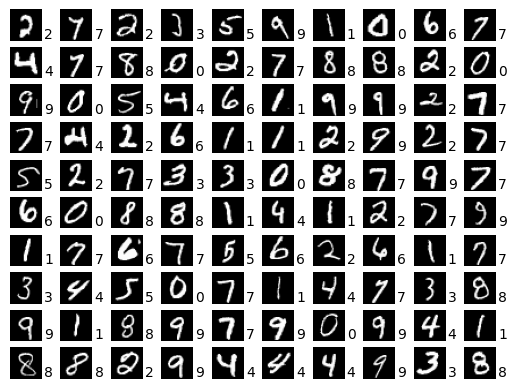

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.006441
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.003604
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.001781
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.020704
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.003844
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.045548
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.003576
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.055331
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.046428
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.037614

Test set: Average loss: 0.0774, Accuracy: 9805/10000 (98.05%)



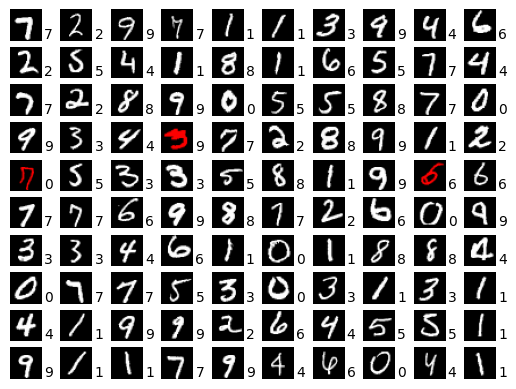

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.011843
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.001784
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000875
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.025606
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.002000
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.002850
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.005697
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.128166
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000708
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.131555

Test set: Average loss: 0.0785, Accuracy: 9822/10000 (98.22%)



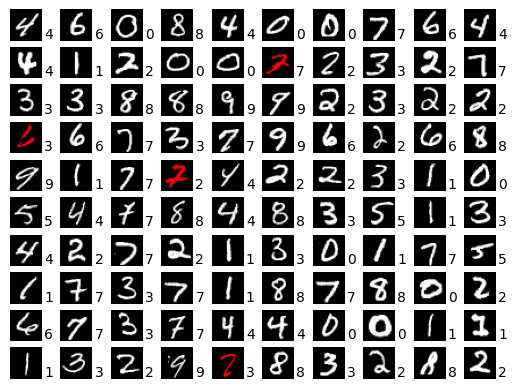

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.002252
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.004421
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.001035
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.002803
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.001059
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000664
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001289
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.001225
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000906
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.032037

Test set: Average loss: 0.0860, Accuracy: 9799/10000 (97.99%)



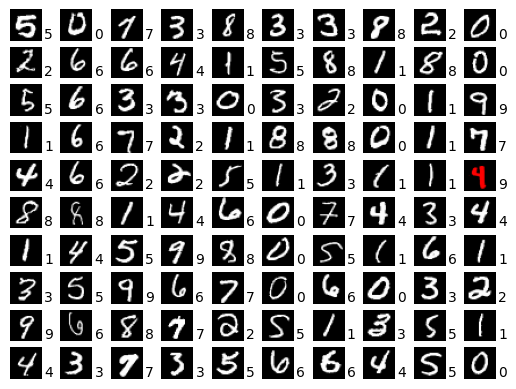

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.001573
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.002020
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000548
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000259
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.001408
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000203
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000199
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.024002
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000323
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.002169

Test set: Average loss: 0.0863, Accuracy: 9813/10000 (98.13%)



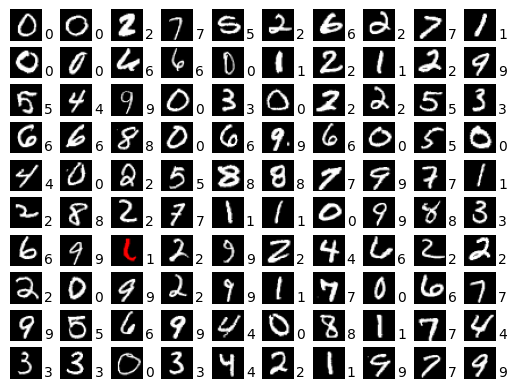

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.179668
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000134
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.002718
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000758
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.025803
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.001509
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000274
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000236
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.002539
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.002097

Test set: Average loss: 0.0892, Accuracy: 9817/10000 (98.17%)



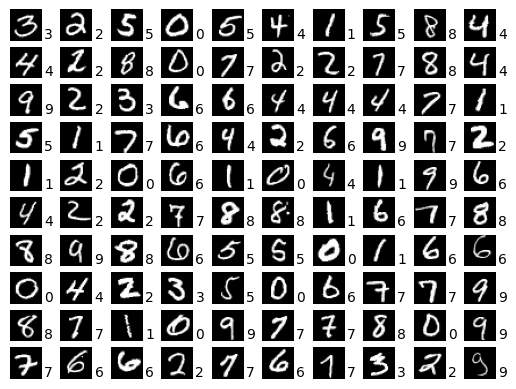

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001835
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000330
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001022
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000491
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.001526
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000305
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.005890
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.004203
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000626
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000337

Test set: Average loss: 0.0898, Accuracy: 9822/10000 (98.22%)



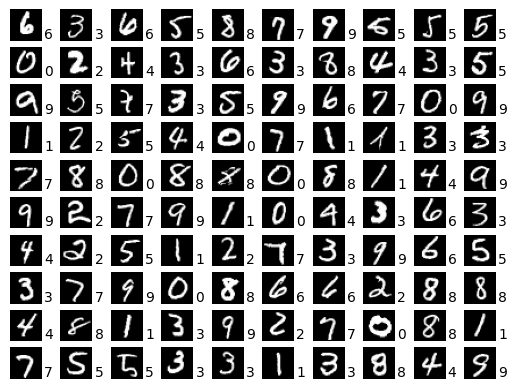

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000700
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000624
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000686
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.002360
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.193505
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000038
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.032014
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000377
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000270
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000112

Test set: Average loss: 0.0912, Accuracy: 9821/10000 (98.21%)



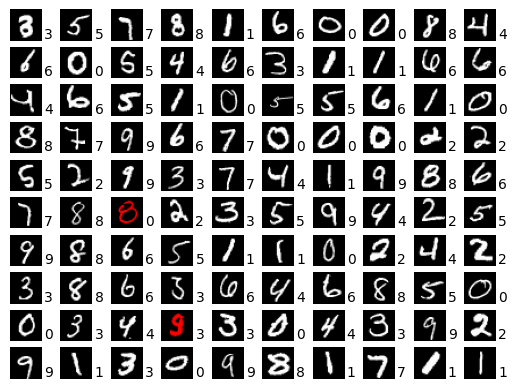

In [22]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = True
device = torch.device('cpu')
kwargs = {}
if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    kwargs = {'num_workers': 1, 'pin_memory': True}
elif use_cuda and torch.backends.mps.is_available():
    device = torch.device('mps')
    kwargs = {'num_workers': 1, 'pin_memory': False}

print(f"Using device: {device}")

# use_cuda = torch.cuda.is_available()
# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# if kwargs == {} and torch.backends.mps.is_available():
#     kwargs = {'num_workers': 1, 'pin_memory': False}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.to(device)

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")